In [1]:
from PIL import Image
import os
import csv
from pdf2image import convert_from_path


# Recorrer los ficheros PDF del directorio y convertirlos a imagenes en escala de grises
folder_path = 'Resources/USE'
files_in_folder = os.listdir(folder_path)
# Filtrar los archivos que son PDF
pdf_files = [
    archivo for archivo in files_in_folder if archivo.lower().endswith('.pdf')]
# Convertir los PDF a imagenes
tests = []
for file in pdf_files:
    pdf_path = os.path.join(folder_path, file)
    # Convertir PDF a imagenes
    images = convert_from_path(
        pdf_path, poppler_path='poppler-24.02.0/Library/bin')
    # Meter en grupos de 2 en el array ya que cada test ocupa dos paginas y convertir a escala grises
    for i in range(0, len(images), 2):
        resized_image_1 = images[i].resize(
            (images[i].width * 2, images[i].height * 2))
        resized_image_2 = images[i +
                                 1].resize((images[i+1].width * 2, images[i+1].height * 2))
        tests.append([resized_image_1.convert('L'),
                     resized_image_2.convert('L')])

In [2]:
# Definir la posición y tamaño de la región a recortar donde estan las respuestas
xDistanceBetweenBoxes = 2143 - 2034
xPosition = 2034
naAnswerXPosition = 3015
yPositionsByPage = [[1785, 1880, 1980, 2073, 2244, 2418, 2516, 2610, 2802, 2897, 2990, 3089, 3258, 3356, 3454, 3550, 3648, 3745, 3840, 4025, 4125, 4222, 4319],
                    [194, 292, 388, 482, 579, 676, 771]]

singleBoxWidth = 50
singleBoxHeight = 50

In [3]:
# Lista con el listado de las respuestas detectadas
final_answers = []
# Iterar sobre cada test realizado cada obtener las respuestas seleccionadas
for test in tests:
    page_1 = test[0]
    page_2 = test[1]

    # Obtener las cajas con las respuestas para cada pagina
    answerBoxesPage1 = [[page_1.crop((xPosition + xDistanceBetweenBoxes*i, yPosition, xPosition + xDistanceBetweenBoxes*i + singleBoxWidth, yPosition + singleBoxHeight)) if i < 7 else
                         page_1.crop((naAnswerXPosition, yPosition, naAnswerXPosition + singleBoxWidth, yPosition + singleBoxHeight)) for i in range(8)] for yPosition in yPositionsByPage[0]]
    answerBoxesPage2 = [[page_2.crop((xPosition + xDistanceBetweenBoxes*i, yPosition, xPosition + xDistanceBetweenBoxes*i + singleBoxWidth, yPosition + singleBoxHeight)) if i < 7 else
                         page_2.crop((naAnswerXPosition, yPosition, naAnswerXPosition + singleBoxWidth, yPosition + singleBoxHeight)) for i in range(8)] for yPosition in yPositionsByPage[1]]
    answerBoxes = answerBoxesPage1 + answerBoxesPage2

    # Calcular el sumatorio de pixeles de cada caja
    answersPixelSum = []
    for i in range(len(answerBoxes)):
        temp_list = []
        for j in range(len(answerBoxes[i])):
            temp_list.append(sum(answerBoxes[i][j].getdata()))
        answersPixelSum.append(temp_list)

    # Obtener la respuesta usando el minimo de la suma de pixeles como la respuesta seleccionada
    correctAnswers = [answer.index(
        min(answer)) + 1 for answer in answersPixelSum]
    final_answers.append(correctAnswers)

In [4]:
# Guardar los datos en un CSV
csv_file_path = 'Results/USEResults.csv'

with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(final_answers)

In [5]:
# Calculo de estadisticas
question_answers = list(zip(*final_answers))
na_count_values = sum([sum([1 for x in row if x == 8])
                      for row in question_answers])
questions_answers_without_na = [
    [x for x in question if x != 8] for question in question_answers]

avg_question = [sum(x)/len(x) for x in questions_answers_without_na]
global_avg = sum(avg_question)/len(avg_question)

print("Número de preguntas sin respuesta: ", na_count_values)
print("Puntuación media por pregunta: ", avg_question)
print("Puntuación media global: ", global_avg)

Número de preguntas sin respuesta:  8
Puntuación media por pregunta:  [4.961538461538462, 4.923076923076923, 5.653846153846154, 4.36, 4.88, 4.0, 4.538461538461538, 4.64, 4.923076923076923, 4.923076923076923, 5.423076923076923, 4.92, 4.615384615384615, 4.3076923076923075, 3.6538461538461537, 3.3846153846153846, 5.1923076923076925, 4.923076923076923, 5.375, 5.730769230769231, 6.0, 5.769230769230769, 5.384615384615385, 5.384615384615385, 5.576923076923077, 6.0, 5.076923076923077, 5.230769230769231, 4.538461538461538, 5.538461538461538]
Puntuación media global:  4.994294871794873


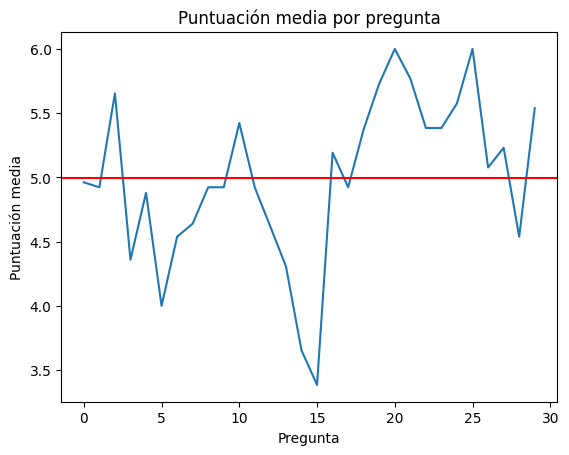

In [6]:
# Mostrar datos en grafico
import matplotlib.pyplot as plt

plt.plot(avg_question)
plt.axhline(y=global_avg, color='r', linestyle='-')
plt.xlabel('Pregunta')
plt.ylabel('Puntuación media')
plt.title('Puntuación media por pregunta')
plt.show()